In [225]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utilitiy functions

In [226]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    return tf.matmul(inputs, w) + b if af is None else af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

prob = lambda p, s: s*p+(1.0-s)*(1.0-p)
log_prob = lambda p, s: tf.log(tf.clip_by_value(prob(p, s), eps, 1.0-eps))

def det_pass(inputs, layer, n, _expect):
    if layer==1:
        inputs = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
    z = prob(add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-_expect-eps,[n,1])), 1, keep_dims=True)

def stc_pass(inputs, layer, n):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = tf.reshape(Bernoulli(probs=z,dtype=tf.float32).sample(n), [n*n*batch_size,nh])
    z = add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid)
    z = tf.reduce_mean(tf.reshape(z,[n,n*batch_size,392]), 0) if layer==1 else z
    z = prob(z, tf.tile(y_,[n,1]))
    z_expect = tf.reduce_mean(tf.reshape(z, [n,batch_size,392]), 0)
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-z_expect-eps, [n,1])), 1, keep_dims=True), z_expect

def fg_cov(f, g, w, n):
    f, g = [tf.reshape(z, [n,batch_size,nh]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mf, mg = [df, dg] if i==0 else [mf+df, mg+dg]
        vg = tf.square(dg) if i==0 else vg+tf.square(dg)
        cov = df*dg if i==0 else cov+df*dg
    return mf/n, mg/n, (cov-mf*mg/n)/(n-1), (vg-tf.square(mg)/n)/(n-1)

def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, nh]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

### Parameters

In [227]:
batch_size = 4
ns = 2
lr = 1e-3
eps = 1e-7
alpha = 0.9
steps = 50000
nh = 100

### Sigmoid belief networks

In [228]:
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", "bxh", 392, nh, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), 
                                 [ns*batch_size, nh]))
h2 = add_layer(sh, "whh", "bhh", nh, nh, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns),
                                  [ns*ns*batch_size, nh]))
y = add_layer(sh2, "why", "bhy", nh, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, batch_size, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(prob(y, tf.tile(y_,[ns**2,1]))/
                    tf.stop_gradient(tf.tile(-prob(y_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
ls = tf.reduce_mean(tf.reshape(ls2, [ns,ns*batch_size, 1]), 0)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]
#saver = tf.train.Saver()

### Gradient estimators

In [229]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    f, f2 = ls, ls2
    m = v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:
        c2 = cv_coef(h2, nn, 2, get_weights("whh", "bhh")) if cf else tf.ones([batch_size*ns,1])        
        c = cv_coef(h, nn, 1, get_weights("wxh", "bxh")) if cf else tf.ones([batch_size,1])   
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-tf.tile(c2,[ns,1])*g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c2)*mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-tf.tile(c,[ns,1])*g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c)*mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2f, dh2g, dh2mg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("whh", "bhh"))
                             for z in [tf.stop_gradient(f2)*log_prob(_h2, sh2),
                                       tf.stop_gradient(g2)*log_prob(_h2, sh2), mg2]]
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh"))
                          for z in [tf.stop_gradient(f)*log_prob(_h, sh),
                                    tf.stop_gradient(g)*log_prob(_h, sh), mg]]        
        b2 = bias_cor(f2, g2, _h2, sh2, nn, 2, get_weights("whh", "bhh"), nh) if cf else [tf.zeros([nh,nh]), tf.zeros([1,nh])]
        b = bias_cor(f, g, _h, sh, nn, 1, get_weights("wxh", "bxh"), 392) if cf else [tf.zeros([392,nh]), tf.zeros([1,nh])]
        
        dh2 = [list(z) for z in dh2f]
        dh = [list(z) for z in dhf]
        for j in range(2):
            dh2[j][0] = (dh2[j][0]/(dh2g[j][0]+eps)-b2[j])*dh2mg[j][0]
            dh[j][0] = (dh[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]

    train_step = opt.apply_gradients(dy+dh2+dh if tr is None else dy+dh2+dh+tr)
    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1), prob(y_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

def cv_coef(p, nn, layer, w):
    p = tf.reshape(p, [ns**(layer-1), batch_size, nh])
    for i in range(ns**(layer-1)):
        pp = p[i]
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=pp, dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sls, sls_expect = stc_pass(ss, layer, nn)
        fh = det_pass(pp, layer, 1, sls_expect)
        dfh = tf.gradients(fh, pp)[0]
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, pp]]
        f = tf.stop_gradient(sls)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/(tf.reduce_sum(vg)+eps)]],[batch_size,1])
        coef = t if i==0 else tf.concat([coef, t], 0)
    return coef

def bias_cor(f, g, p, s, nn, layer, w, dim):
    ff, gg = [tf.stop_gradient(z)*log_prob(s, p) for z in [f,g]]
    _f, _g = [tf.reshape(z,[ns,ns**(layer-1)*batch_size,nh]) for z in [ff,gg]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(z[i], w), 0) for z in [_f, _g]]
        mfg, mg = [df/(dg+eps), dg] if i==0 else [mfg+df/(dg+eps), mg+dg]
        sfgg = df if i==0 else sfgg+df
    mg /= ns
    sfgg = (sfgg-mg*mfg)/(ns-1)
    b = sfgg/(mg+eps)
    return b[0:dim], b[dim]
    

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [230]:
def train(train_op):
    with tf.Session() as sess:
        bl = 0.
        vr = 0.
        loss_rec = np.empty((1000, steps/1000))
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size, shuffle=True)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]
            
            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]   
            loss_rec[i%1000, i/1000] = res[-3]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0),
                
    return loss_rec, batch_xs, batch_ys, res[1]

In [ ]:
train_op = gd_est(1, linear=False, cf=True, sta=False, nn=4)
result = train(train_op)
mpr_b = result[0]
#np.save("dn_20_4.npy", dn_20_4)

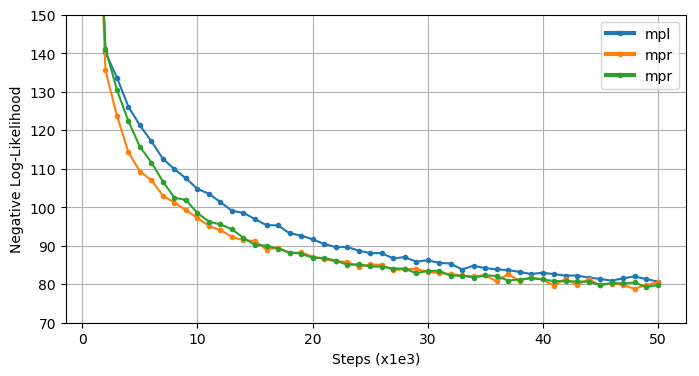

In [232]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
#plt.xlim(0, 50)
plt.ylim(70,150)

plot_banded_error(mpl, "mpl")
plot_banded_error(mpr, "mpr")
plot_banded_error(mpr_b, "mpr")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('foo.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

In [ ]:
def ratio_cv(p, s, layer, w, f, g, mg, nn, dim, cf):
    _f, _g = [tf.reshape(z, [ns**layer,batch_size,1]) for z in [f,g]]
    _p, _s, _mg = [tf.reshape(z, [ns**layer,batch_size,nh]) for z in [p, s, tf.tile(mg,[ns,1])]]
    for i in range(ns**layer):
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), w)
                          for z in [tf.stop_gradient(_f[i])*log_prob(_p[i], _s[i]),
                                    tf.stop_gradient(_g[i])*log_prob(_p[i], _s[i]), _mg[i]]]
        t = [list(z) for z in dhf]
        b = bias_cor(_p[i], nn, layer, w, dim) if cf else [tf.zeros([dim,nh]), tf.zeros([1,nh])]
        for j in range(2):
            t[j][0] = (t[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]/(ns**layer)
        if i==0:
            dh = t
        else:
            dh[0][0] += t[0][0]
            dh[1][0] += t[1][0]
    return dh

def bias_cor(p, nn, layer, w, dim):
    ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=p, dtype=tf.float32).sample(nn), 
                                     [nn*batch_size, nh]))
    sls, sls_expect = stc_pass(ss, layer, nn)
    fh = det_pass(p, layer, 1, sls_expect)
    dfh = tf.gradients(fh, p)[0]
    _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, p]]
    f = tf.stop_gradient(sls)*log_prob(_p, ss)
    g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
    
    f, g = [tf.reshape(z, [nn,batch_size,nh]) for z in [f,g]]
    for i in range(nn):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mfg, mg = [df/dg, dg] if i==0 else [mfg+df/dg, mg+dg]
        cov = df if i==0 else cov+df
    b = tf.reduce_sum(cov-mfg*mg/nn)/(nn-1)/tf.reduce_sum(mg/nn)
    return b, b